In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

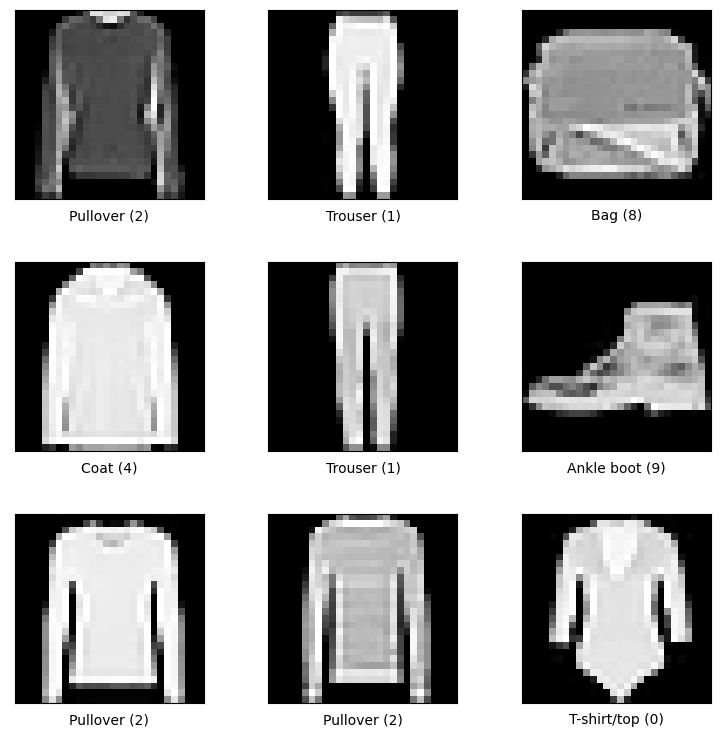

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_train, ds_info)

In [3]:
batch_size = 128
image_shape = (32, 32, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
    return image

In [4]:
ds_train = ds_train.map(preprocess).cache().shuffle(ds_info.splits['train'].num_examples).batch(batch_size, drop_remainder=True).repeat()

In [5]:
train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

469


In [14]:
class WGAN():
    def __init__(self, input_shape):
        
        self.z_dim = 128
        self.input_shape = input_shape
        
        # losses 
        self.loss_critic_real = {}
        self.loss_critic_fake = {}
        self.loss_critic = {}
        self.loss_generator = {}
        
        # critic
        self.n_critic = 5
        self.critic = self.build_critic()
        self.critic.trainable = False
        
        self.optimizer_critic = RMSprop(5e-5)
        
        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = RMSprop(5e-5))
        self.critic.trainable = True
        
    def wasserstein_loss(self, y_true, y_pred):
        w_loss = -tf.reduce_mean(y_true*y_pred)
        return w_loss
    
    def build_generator(self):
        
        DIM = 128
        model = tf.keras.Sequential(name='Generator')
        
        model.add(layers.Input(shape=[self.z_dim]))
        
        model.add(layers.Dense(4*4*4*DIM)) # DIM = 128
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,4*DIM)))
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(2*DIM, 5, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(DIM, 5, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh'))
        
        return model
    
    def build_critic(self):
        
        DIM = 128
        model = tf.keras.Sequential(name='critics')
        
        model.add(layers.Input(shape=self.input_shape))
        
        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same'))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        
        return model
    
    def train_critic(self, real_images, batch_size):
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input)
        
        with tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)
            
            # total loss
            total_loss = loss_fake + loss_real
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))
            
        for layer in self.critic.layers:
            weights = layer.get_weights()
            weights = [tf.clip_by_value(w, -0.01, 0.01) for w in weights]
            layer.set_weights(weights)
            
        return loss_fake, loss_real
    
    def train(self, data_generator, batch_size, steps, interval=200):
        
        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)
        
        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
                
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            
            self.loss_critic_real[i] = loss_real.numpy()
            self.loss_critic_fake[i] = loss_fake.numpy()
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss
            
            if i%interval == 0:
                msg = 'Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f} critic_real {:.4f}'.format(i, g_loss, critic_loss, loss_fake, loss_real)
                print(msg)
                
                fake_images = self.generator.predict(val_g_input)
                self.plot_images(fake_images)
                self.plot_losses()
                
    def plot_images(self, images):
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*2.5, grid_row*2.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1] == 1:
                    axarr[col].imshow(images[col, :, :, 0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off')
        plt.show()
        
    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(2, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title('Critic loss')
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title('Generator loss')
        
        plt.xlabel('Steps')
        plt.show()
                    

In [15]:
wgan = WGAN(image_shape)

In [16]:
wgan.generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 batch_normalization_7 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 8, 8, 512)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 256)         32

In [17]:
wgan.critic.summary()

Model: "critics"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       3328      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         819456    
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 512)         3277312   
                                                           

4/4 [==============================] - 0s 5ms/step
Step 0: g_loss -0.0001 critic_loss -0.0003 critic fake 0.0001 critic_real -0.0004
4/4 [==============================] - 0s 5ms/step


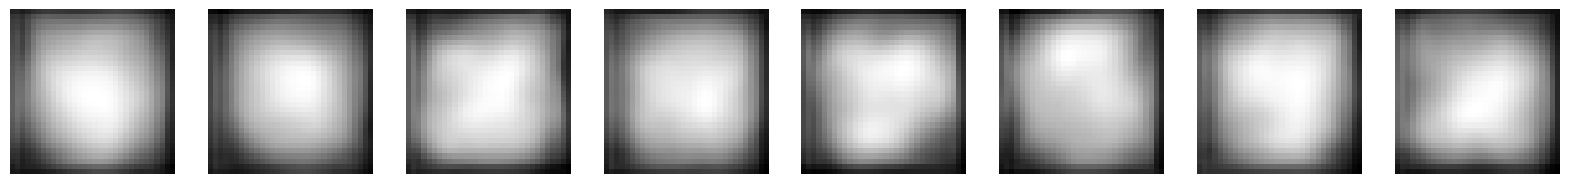

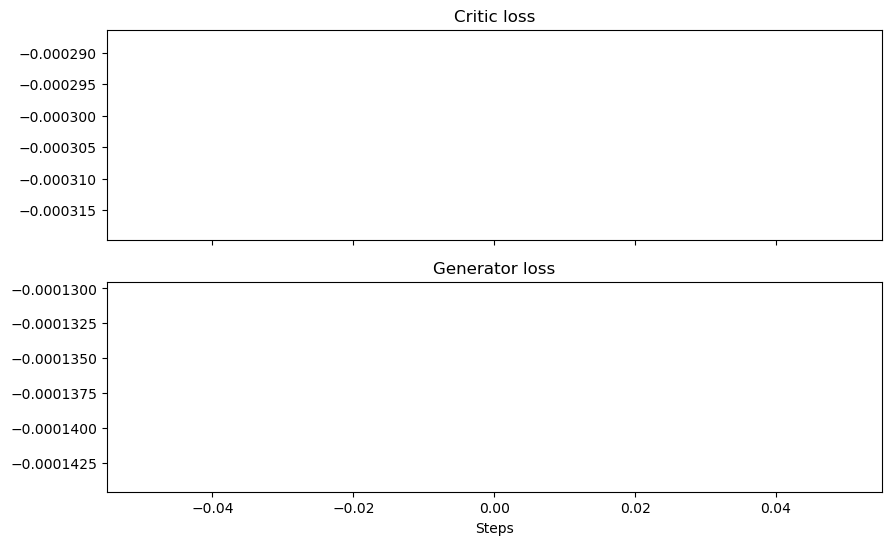

4/4 [==============================] - 0s 5ms/step
Step 100: g_loss -34.9804 critic_loss -13.3660 critic fake -9.6637 critic_real -3.7024
4/4 [==============================] - 0s 6ms/step


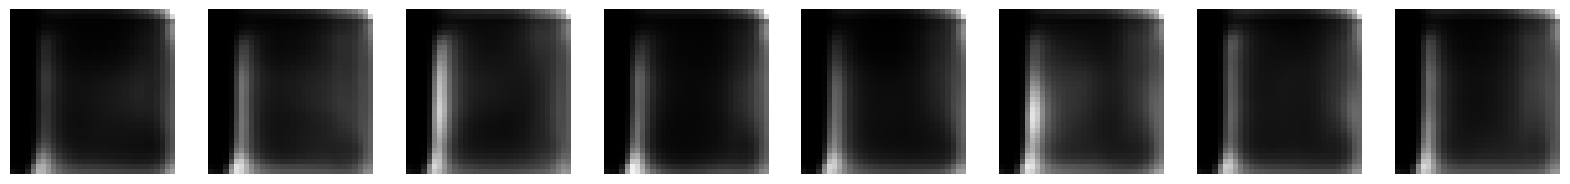

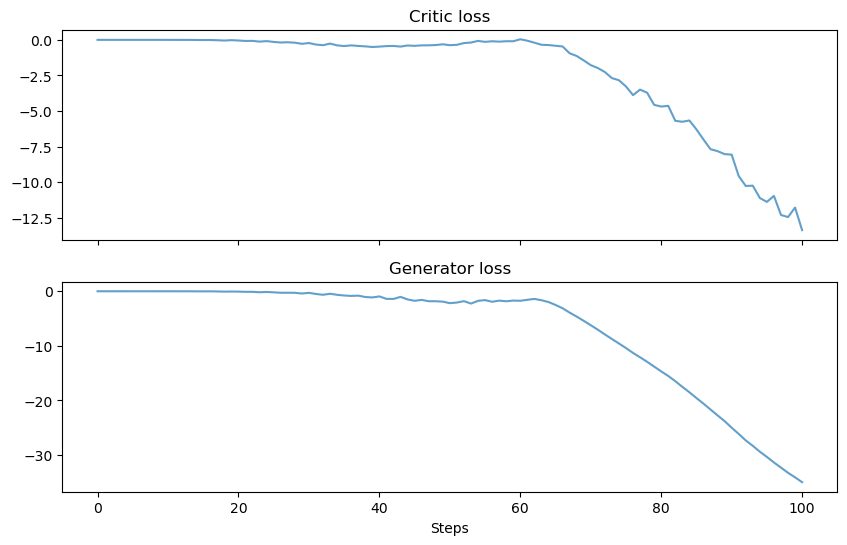

4/4 [==============================] - 0s 6ms/step
Step 200: g_loss 2.4092 critic_loss -4.4169 critic fake -5.7237 critic_real 1.3068
4/4 [==============================] - 0s 7ms/step


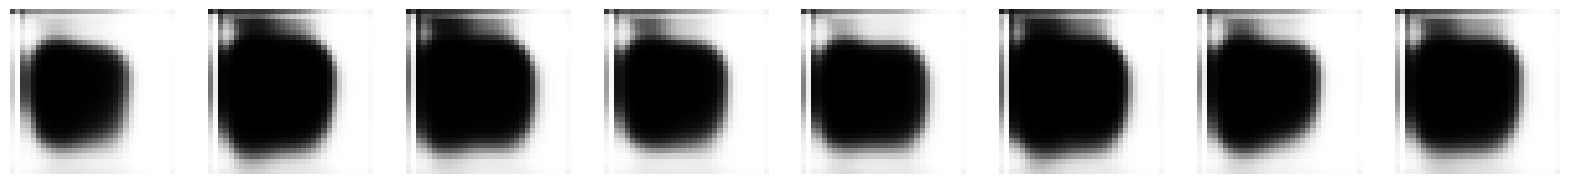

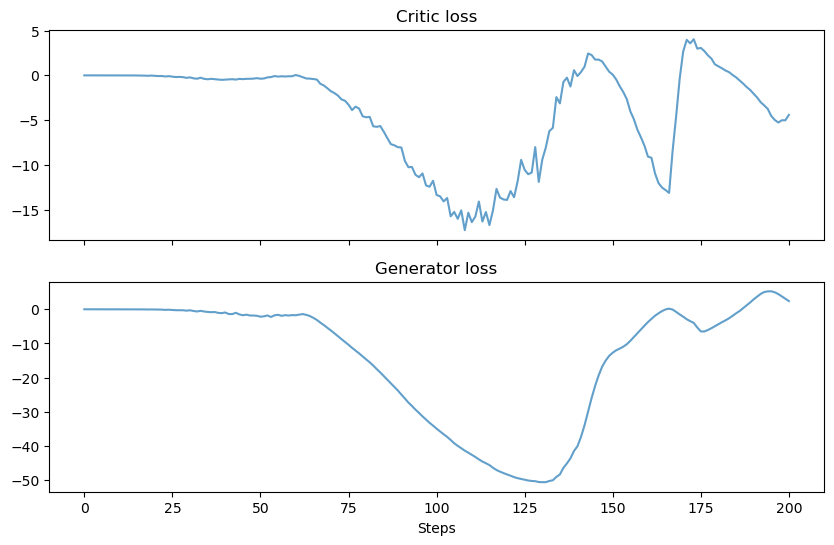

4/4 [==============================] - 0s 6ms/step
Step 300: g_loss -107.1441 critic_loss -18.7169 critic fake 26.6408 critic_real -45.3577
4/4 [==============================] - 0s 6ms/step


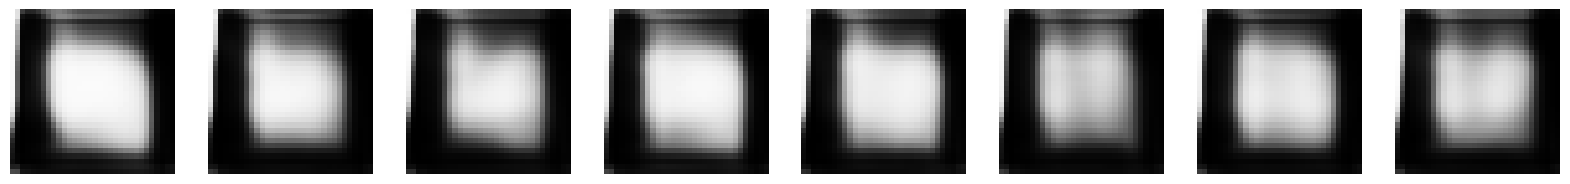

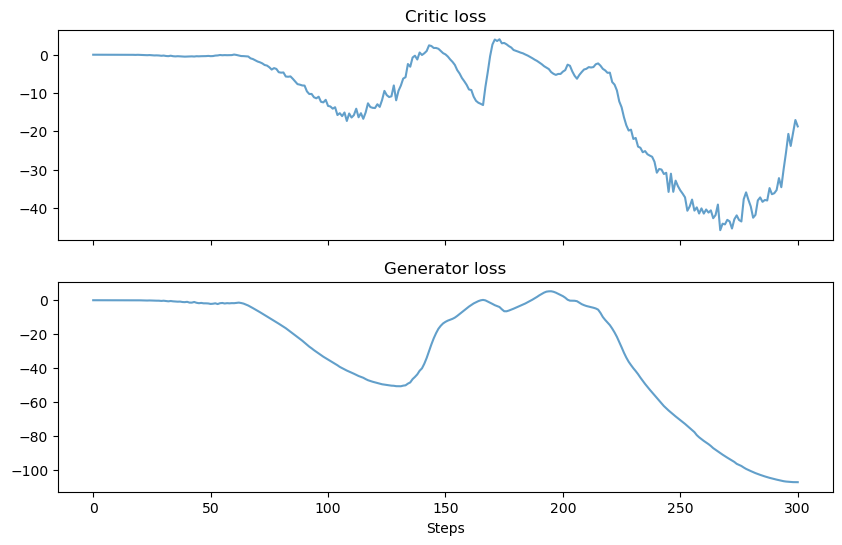

4/4 [==============================] - 0s 5ms/step
Step 400: g_loss -1.7218 critic_loss -2.2140 critic fake 0.5284 critic_real -2.7425
4/4 [==============================] - 0s 5ms/step


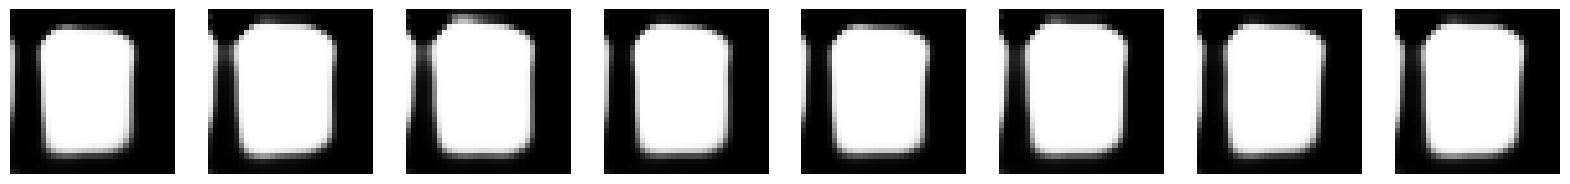

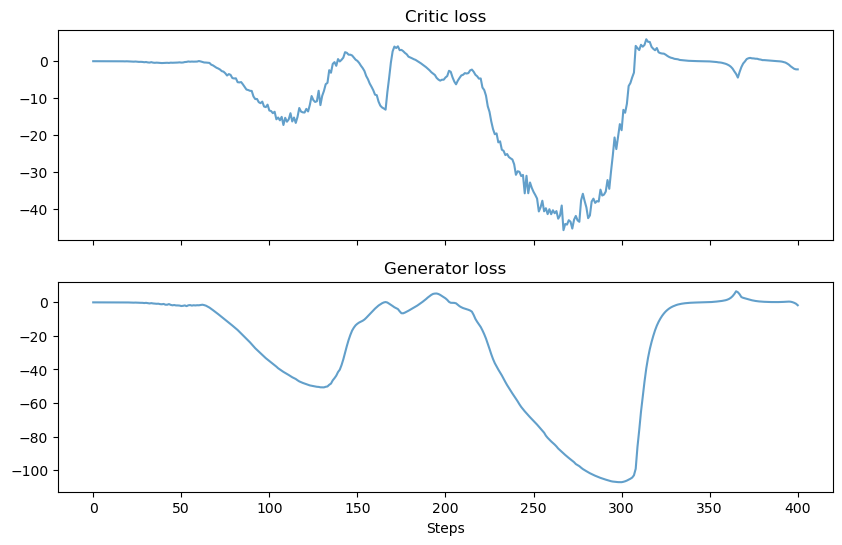

4/4 [==============================] - 0s 5ms/step
Step 500: g_loss 0.9619 critic_loss 0.0608 critic fake -0.7345 critic_real 0.7953
4/4 [==============================] - 0s 5ms/step


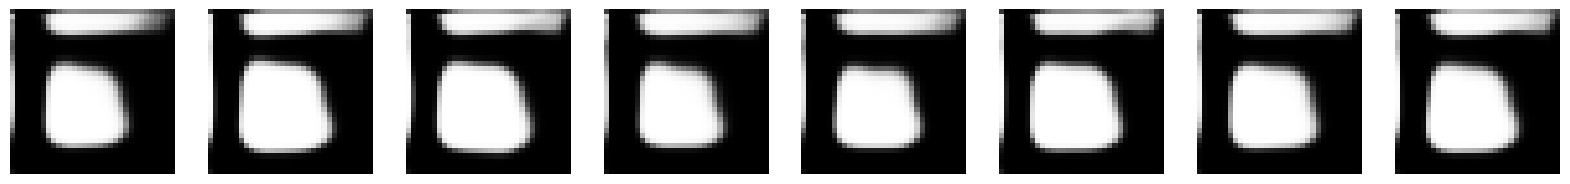

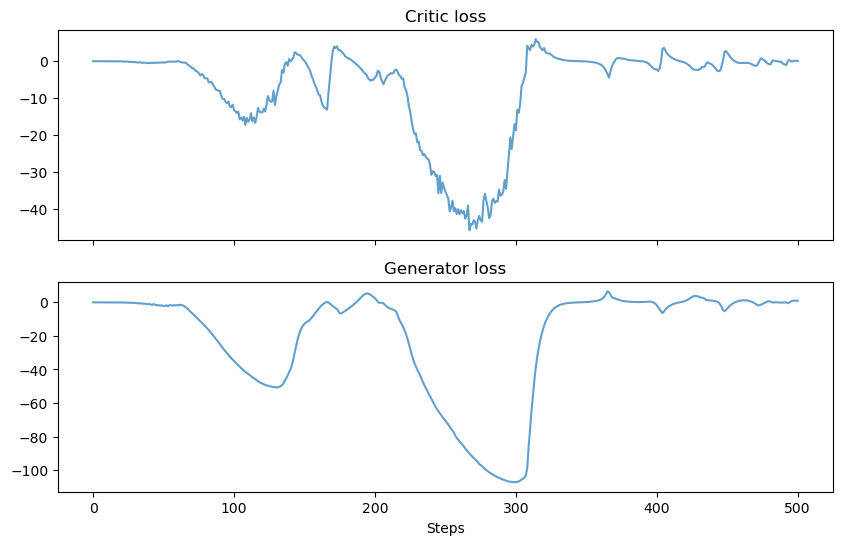

4/4 [==============================] - 0s 5ms/step
Step 600: g_loss 0.4410 critic_loss -0.3738 critic fake -0.4524 critic_real 0.0787
4/4 [==============================] - 0s 5ms/step


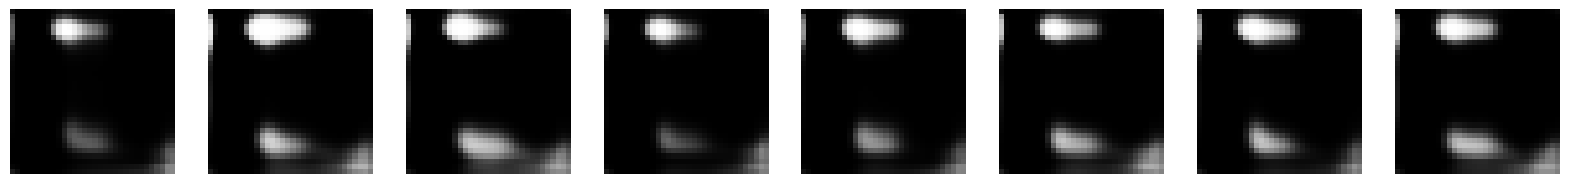

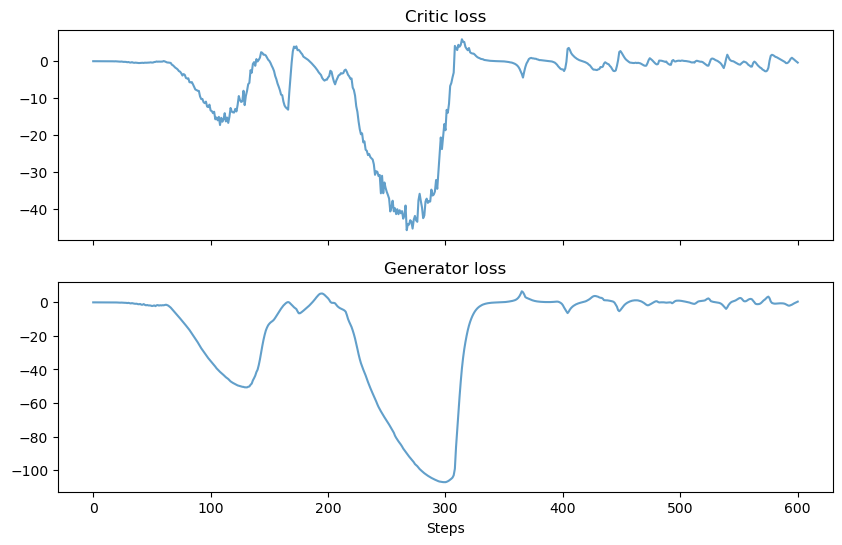

4/4 [==============================] - 0s 5ms/step
Step 700: g_loss -1.7129 critic_loss 0.6199 critic fake 1.3192 critic_real -0.6993
4/4 [==============================] - 0s 5ms/step


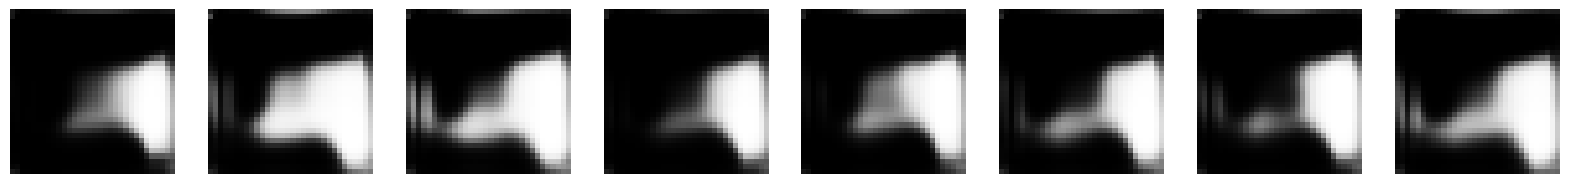

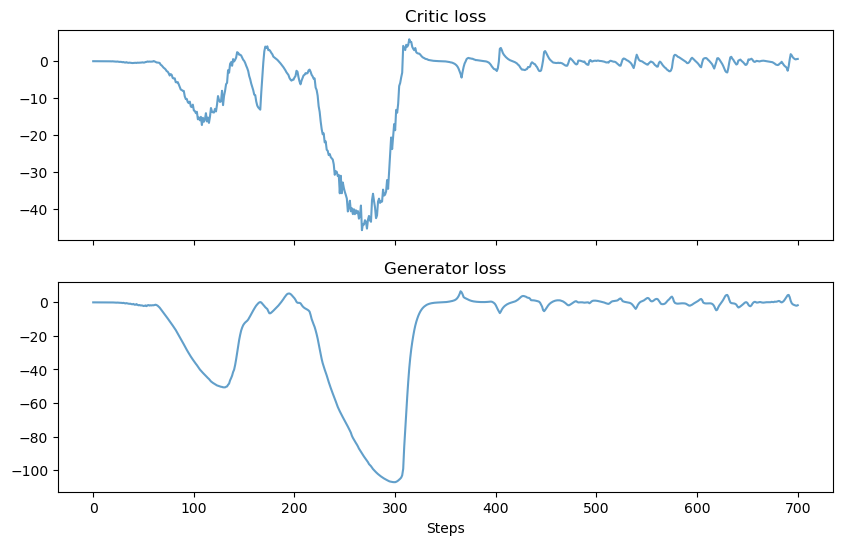

4/4 [==============================] - 0s 5ms/step
Step 800: g_loss 0.1718 critic_loss 0.0130 critic fake -0.0800 critic_real 0.0930
4/4 [==============================] - 0s 5ms/step


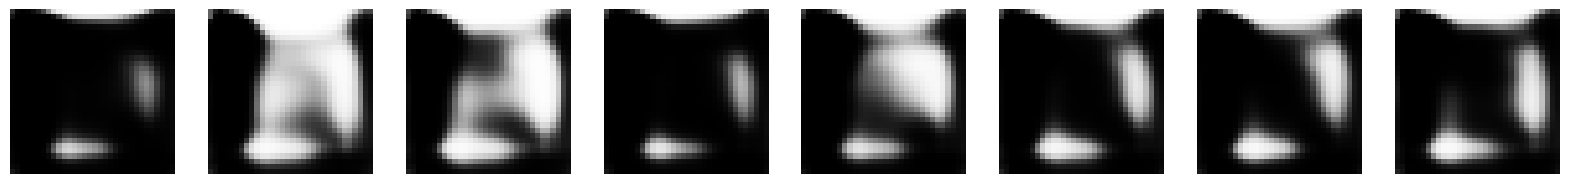

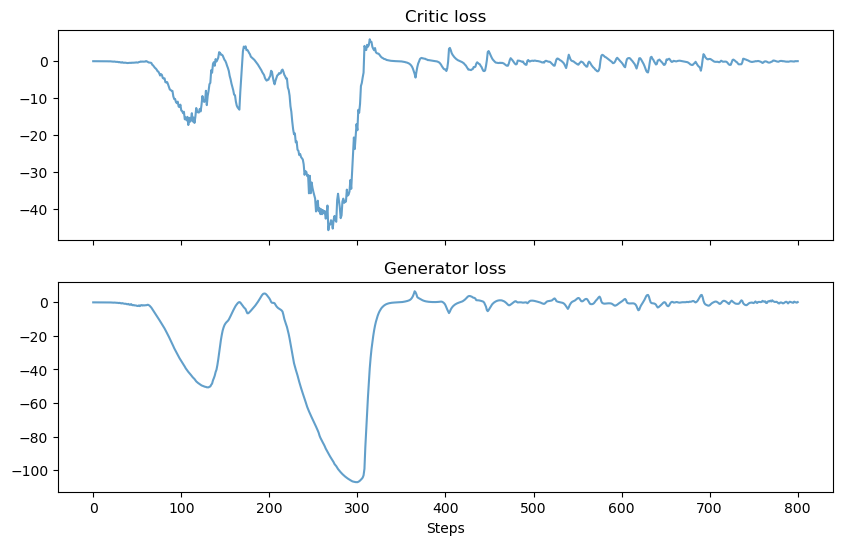

4/4 [==============================] - 0s 6ms/step
Step 900: g_loss -0.2908 critic_loss 0.2331 critic fake 0.3217 critic_real -0.0886
4/4 [==============================] - 0s 6ms/step


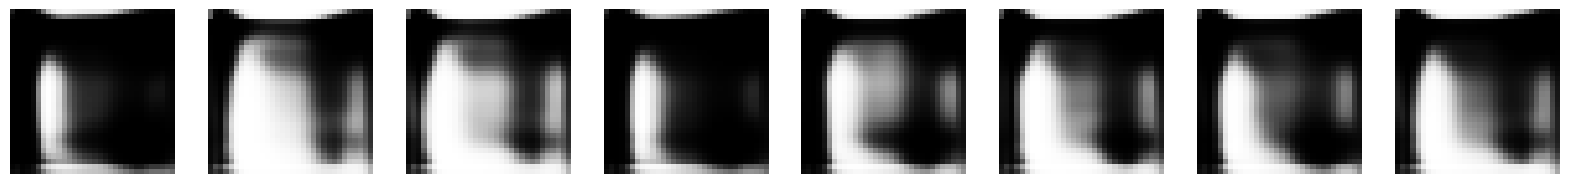

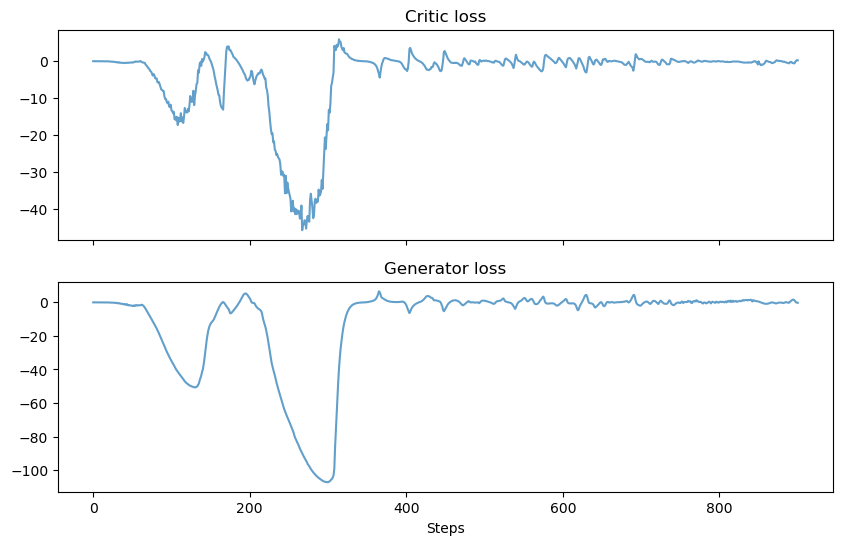

4/4 [==============================] - 0s 5ms/step
Step 1000: g_loss -0.4438 critic_loss -0.2596 critic fake 0.5101 critic_real -0.7698
4/4 [==============================] - 0s 6ms/step


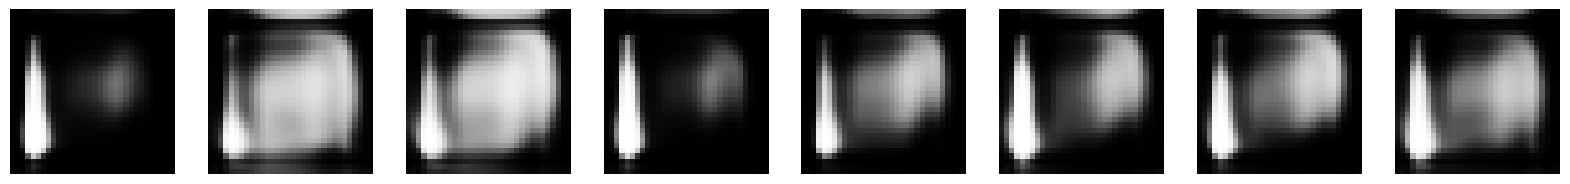

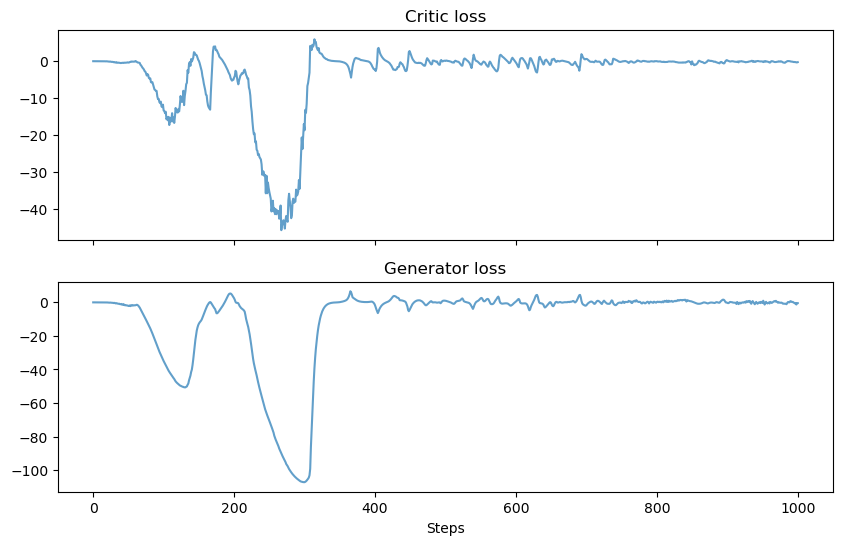

4/4 [==============================] - 0s 6ms/step
Step 1100: g_loss -0.1060 critic_loss -0.1339 critic fake -0.1534 critic_real 0.0195
4/4 [==============================] - 0s 5ms/step


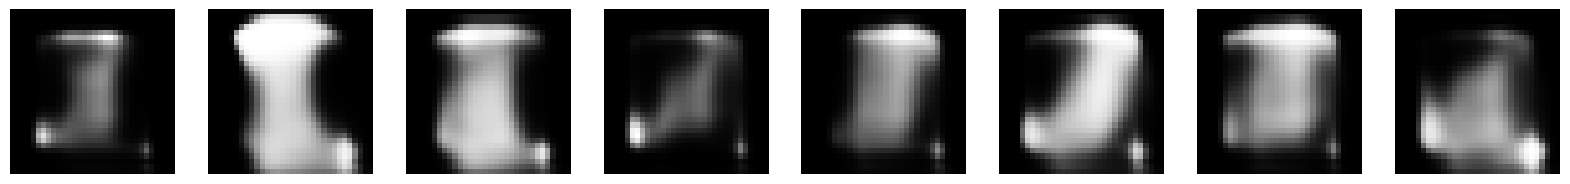

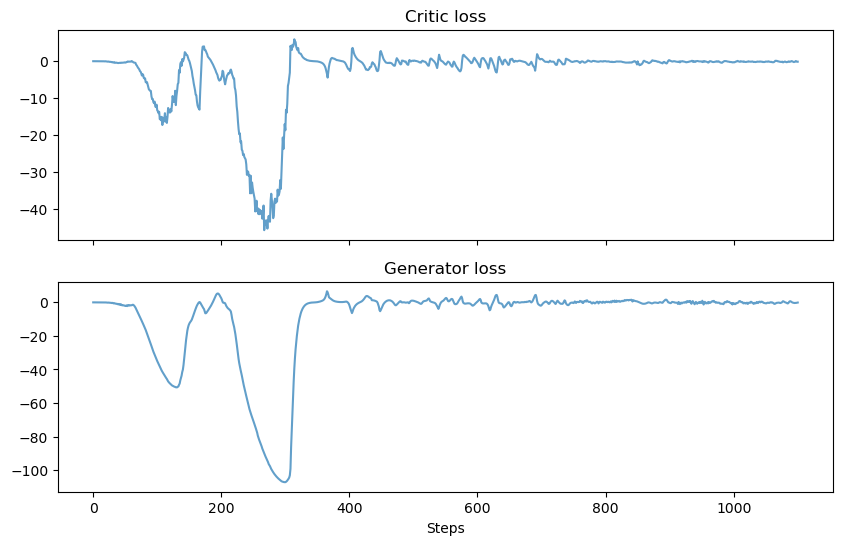

4/4 [==============================] - 0s 6ms/step
Step 1200: g_loss -0.2101 critic_loss -0.0549 critic fake 0.3180 critic_real -0.3729
4/4 [==============================] - 0s 5ms/step


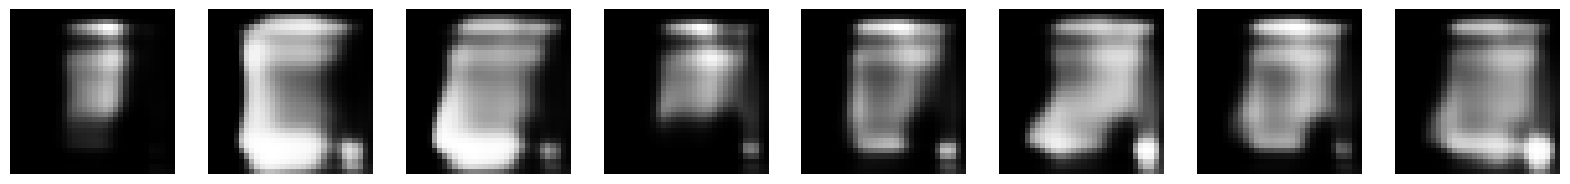

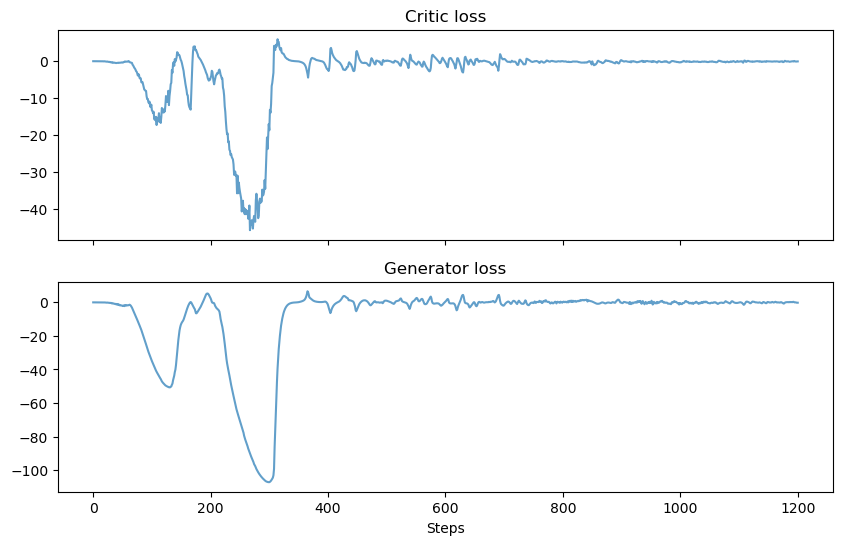

4/4 [==============================] - 0s 6ms/step
Step 1300: g_loss 0.5116 critic_loss -0.0190 critic fake -0.3070 critic_real 0.2881
4/4 [==============================] - 0s 6ms/step


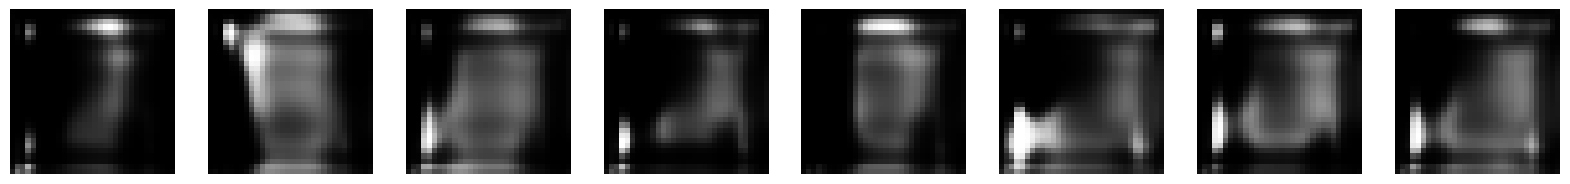

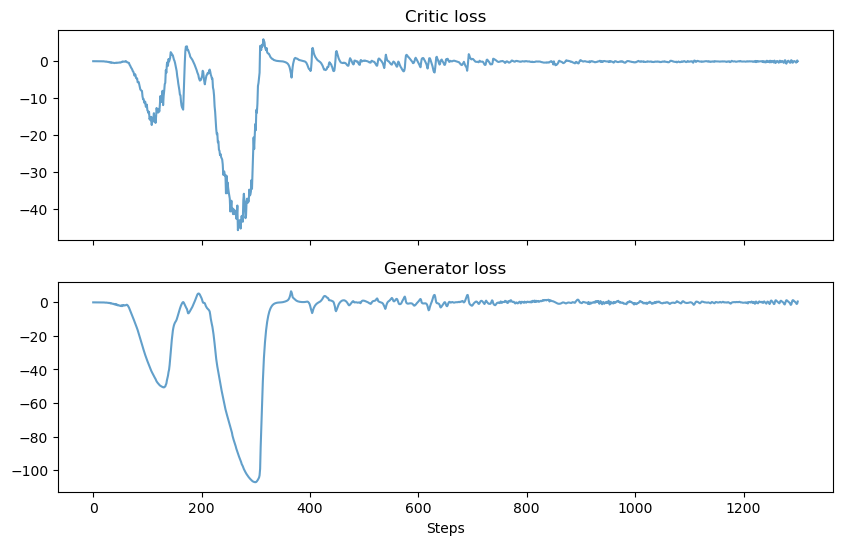

4/4 [==============================] - 0s 6ms/step
Step 1400: g_loss 0.5356 critic_loss -0.0463 critic fake -0.3440 critic_real 0.2976
4/4 [==============================] - 0s 5ms/step


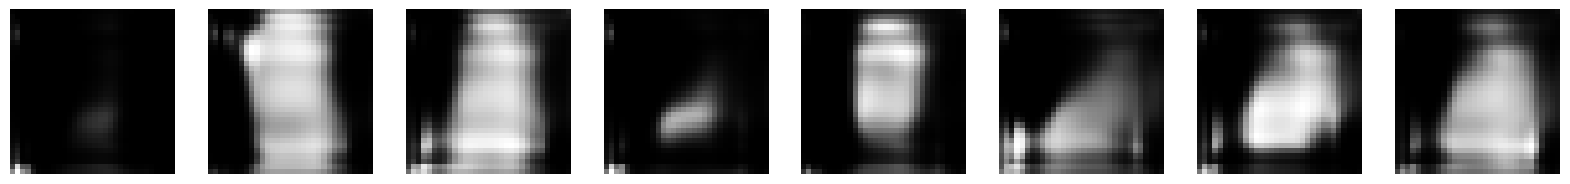

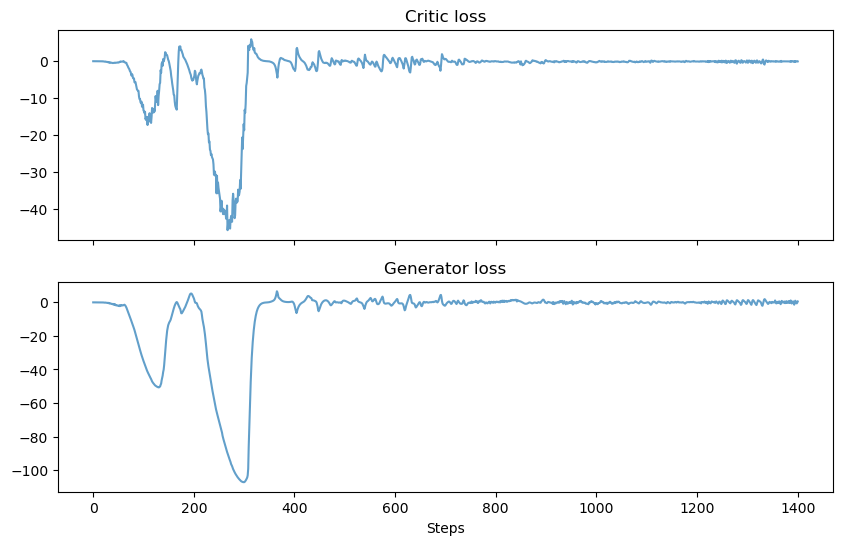

4/4 [==============================] - 0s 7ms/step
Step 1500: g_loss 0.4546 critic_loss -0.0160 critic fake -0.2858 critic_real 0.2698
4/4 [==============================] - 0s 7ms/step


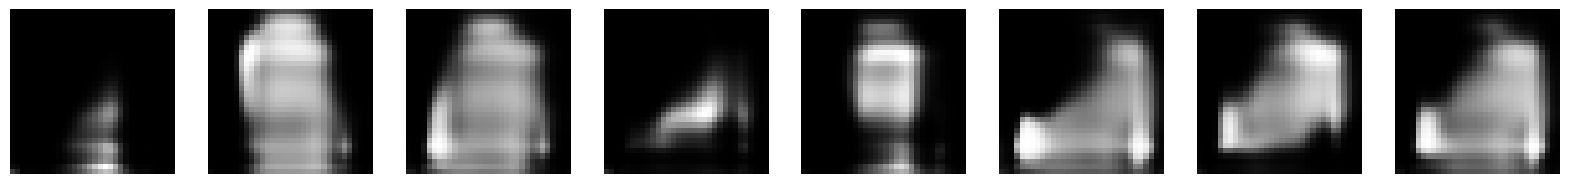

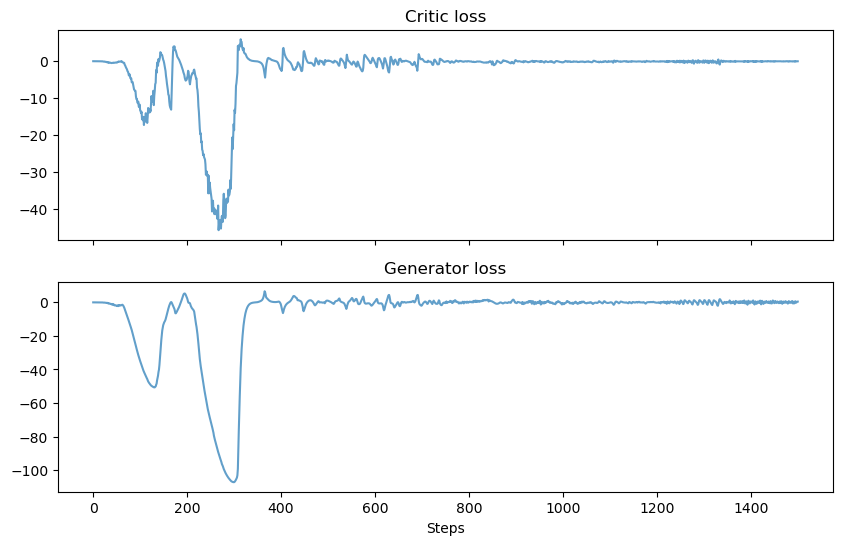

4/4 [==============================] - 0s 6ms/step
Step 1600: g_loss 0.9972 critic_loss -0.0855 critic fake -0.7809 critic_real 0.6955
4/4 [==============================] - 0s 6ms/step


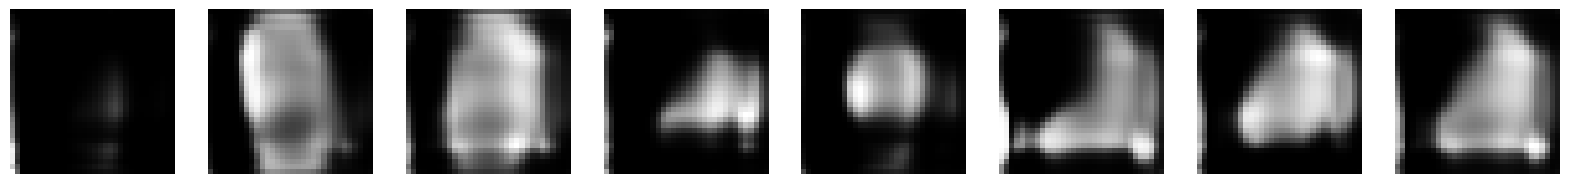

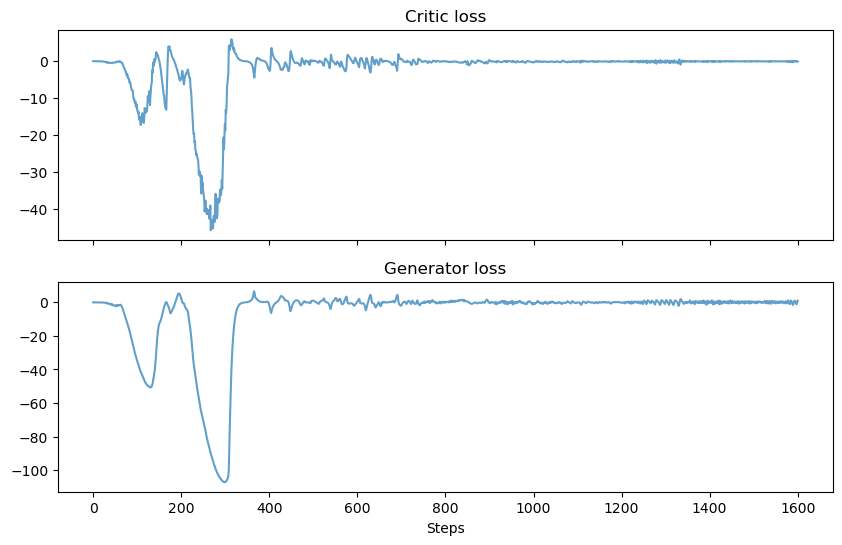

4/4 [==============================] - 0s 6ms/step
Step 1700: g_loss -0.8126 critic_loss -0.1032 critic fake 0.5817 critic_real -0.6850
4/4 [==============================] - 0s 6ms/step


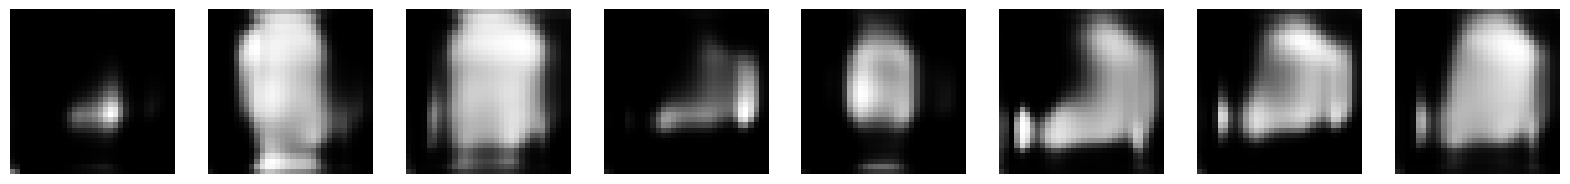

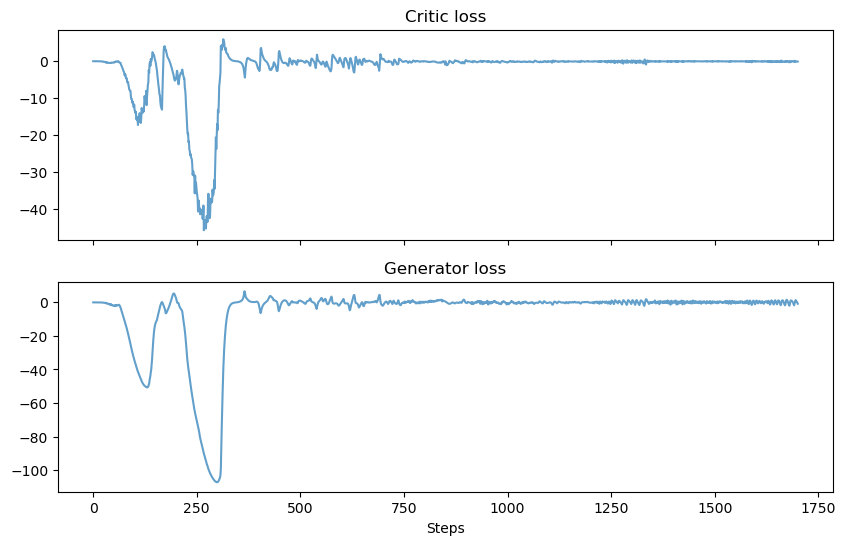

4/4 [==============================] - 0s 6ms/step
Step 1800: g_loss 0.2113 critic_loss -0.0661 critic fake -0.2486 critic_real 0.1825
4/4 [==============================] - 0s 5ms/step


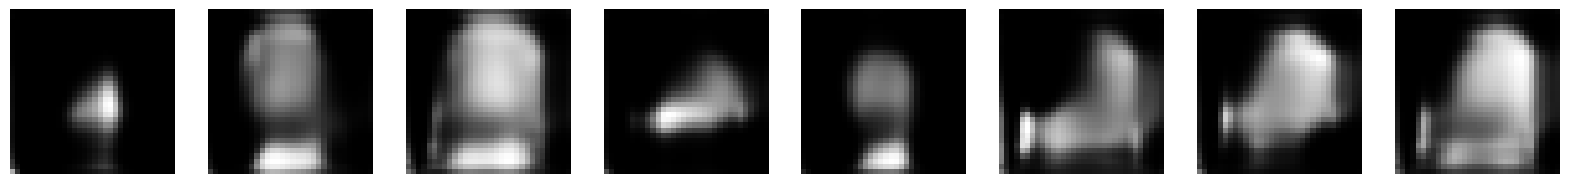

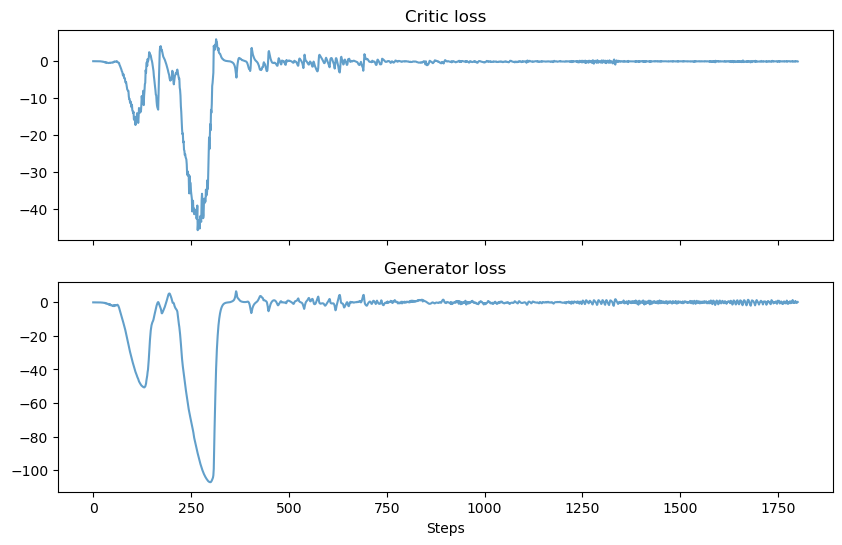

4/4 [==============================] - 0s 5ms/step
Step 1900: g_loss 0.3065 critic_loss -0.0867 critic fake -0.0922 critic_real 0.0055
4/4 [==============================] - 0s 6ms/step


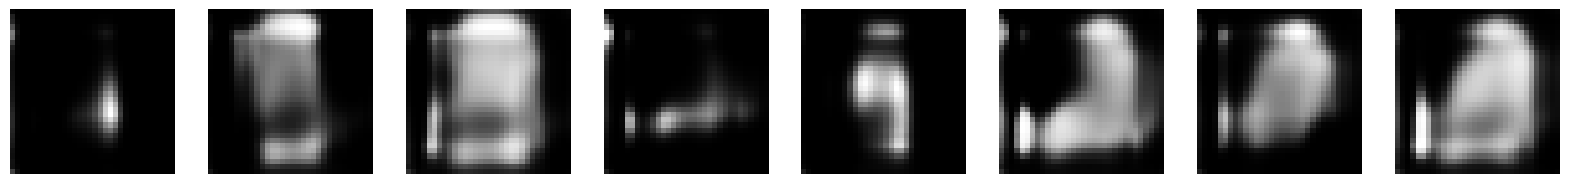

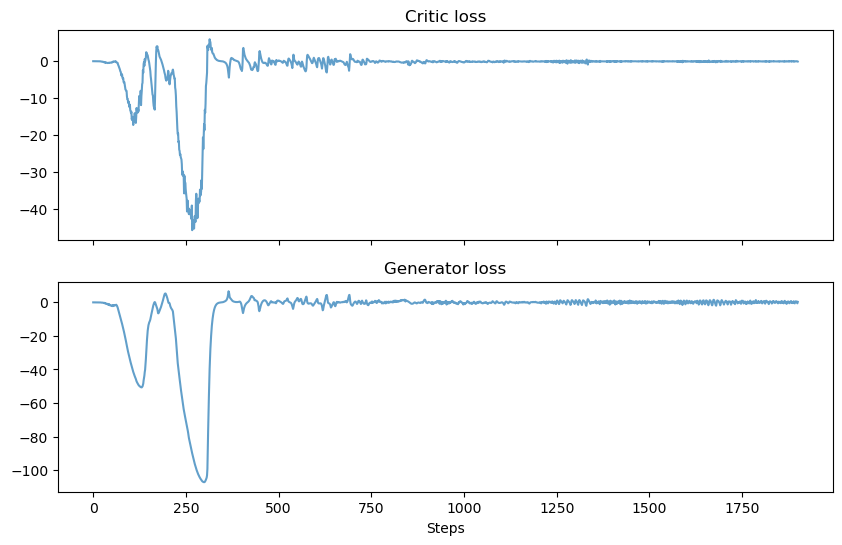

4/4 [==============================] - 0s 5ms/step


In [18]:
wgan.train(iter(ds_train), batch_size, 2000, 100)